In [5]:
%pylab inline
%config InlineBackend.figure_format='retina'

from SuchTree import SuchTree, SuchLinkedTrees
import seaborn
import pandas
import dendropy
import numpy
from scipy.stats import pearsonr, kendalltau
from os import listdir
from itertools import combinations

Populating the interactive namespace from numpy and matplotlib


In [124]:
%time

forest = {}
for t in listdir( 'data/tolmarkers' ) :
    forest[ t.split('.treefile')[0][2:] ] = SuchTree( 'data/tolmarkers/' + t )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


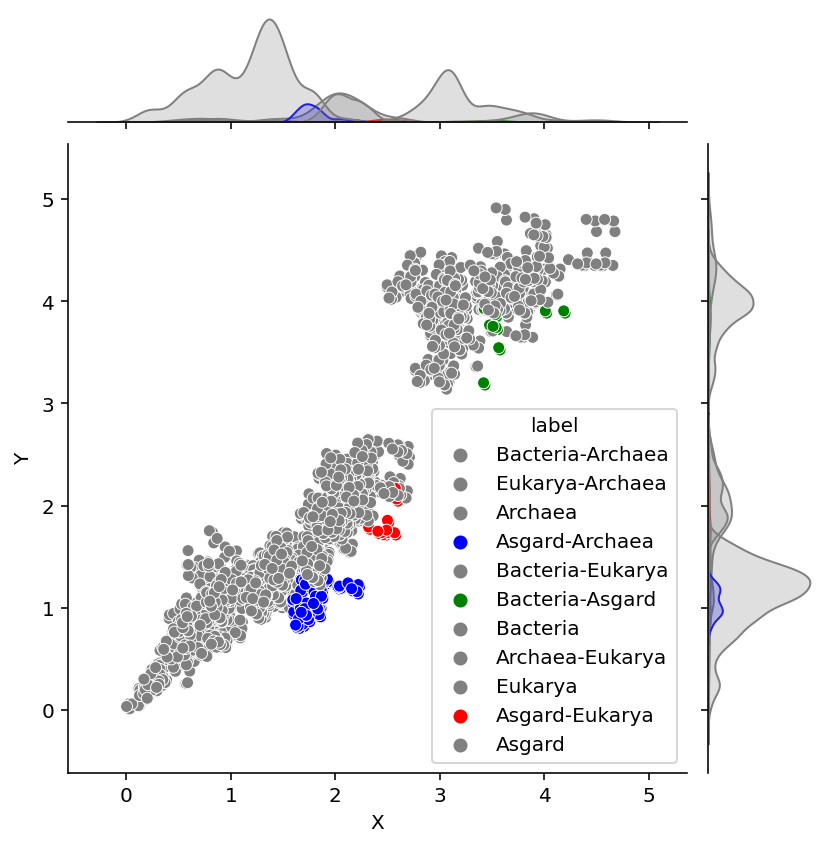

In [156]:
domains = { a:b for a,b in [ line.strip().split() for line in open( 'data/domains_asgard.txt' ) ] }

def xdomain_pairs( T1, T2, domains ) :
    '''
    T1, T2  : a pair of trees with shared leaf nodes
    domains : a dictionary of leaf names mapped to their domains
    returns : dataframe of paired distances labeled by domain membership
    '''
    leafs = set( T1.leafs.keys() ) & set( T2.leafs.keys() )
    pairs = list( combinations( leafs, 2 ) )
    label = [ '-'.join( set( (domains[a],domains[b]) ) ) for a,b in pairs ]
    X     = T1.distances_by_name( pairs )
    Y     = T2.distances_by_name( pairs )
    return pandas.DataFrame( { 'X' : X, 'Y' : Y, 'label' : label } )

df = xdomain_pairs( forest['COG01559'], 
                    forest['COG01762'], 
                    domains )

palette = { 'Archaea'           : 'gray',
            'Archaea-Eukarya'   : 'gray',
            'Asgard'            : 'gray',
            'Asgard-Archaea'    : 'blue',
            'Asgard-Eukarya'    : 'red',
            'Bacteria'          : 'gray',
            'Bacteria-Archaea'  : 'gray',
            'Bacteria-Asgard'   : 'green',
            'Bacteria-Eukarya'  : 'gray',
            'Eukarya'           : 'gray',
            'Eukarya-Archaea'   : 'gray'}

seaborn.jointplot( x='X', y='Y', 
                   hue='label', 
                   palette=palette, 
                   data=df )

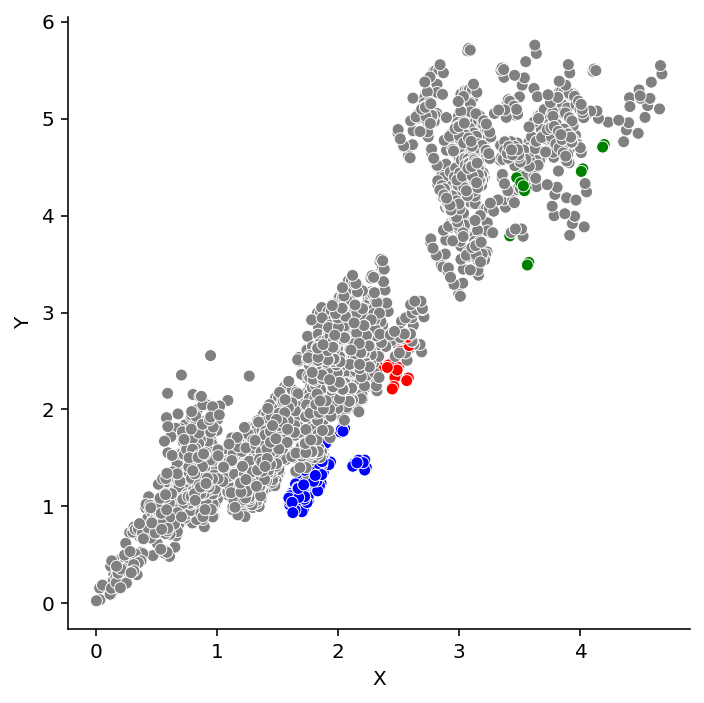

In [157]:
df = xdomain_pairs( forest['COG01559'], 
                    forest['COG04256'], 
                    domains )

seaborn.relplot( x='X', y='Y', hue='label', data=df, palette=palette, legend=None )

* If the Asgard-Archaea centroid is closer to the origin than the Asgard-Eukarya -> 3D model is supported
* If the Asgard-Eukarya centroid is closer to the origin than the Asgard-Archaea -> 3D model is supported

In [165]:
df = xdomain_pairs( forest[a], forest[b], domains )
df.append([ { 'Xlabel' : a, 'Ylabel' : b } ]*len(df))

,X,Y,label,Xlabel,Ylabel
0,2.944144,2.189855,Bacteria-Archaea,NaN,NaN
1,3.190128,2.490196,Bacteria-Eukarya,NaN,NaN
2,3.614703,2.331202,Bacteria-Archaea,NaN,NaN
3,2.587531,1.794541,Bacteria-Archaea,NaN,NaN
4,3.358454,2.281219,Bacteria-Eukarya,NaN,NaN
...,...,...,...,...,...
3076,NaN,NaN,NaN,COG04091,COG04240
3077,NaN,NaN,NaN,COG04091,COG04240
3078,NaN,NaN,NaN,COG04091,COG04240
3079,NaN,NaN,NaN,COG04091,COG04240


In [159]:
%time

distances = {}
for a, b in combinations( forest.keys(), 2 ) :
    distances[ frozenset( ( a, b ) ) ] = xdomain_pairs( forest[a], forest[b], domains )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


/home/russell/opt/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


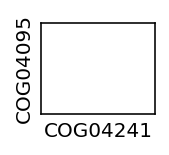

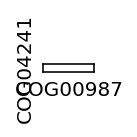

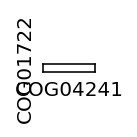

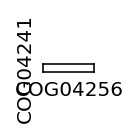

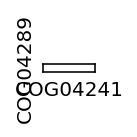

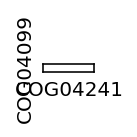

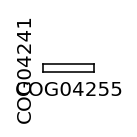

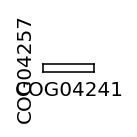

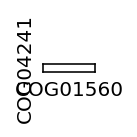

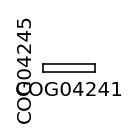

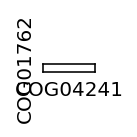

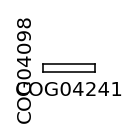

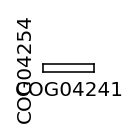

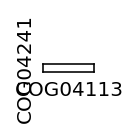

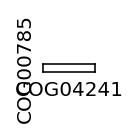

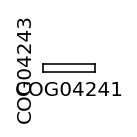

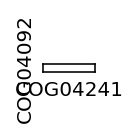

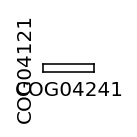

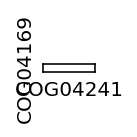

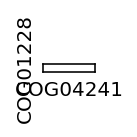

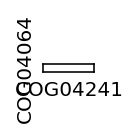

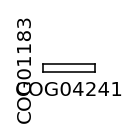

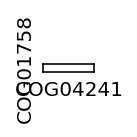

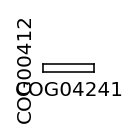

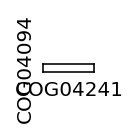

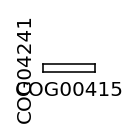

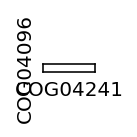

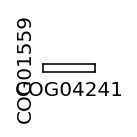

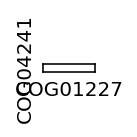

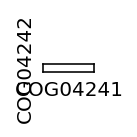

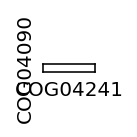

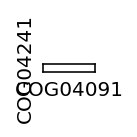

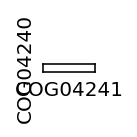

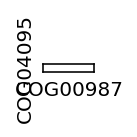

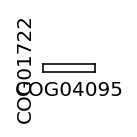

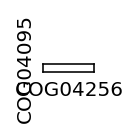

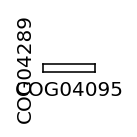

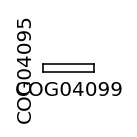

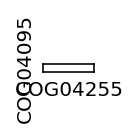

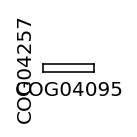

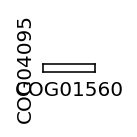

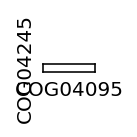

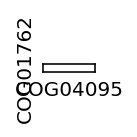

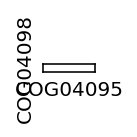

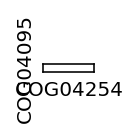

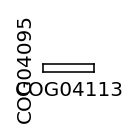

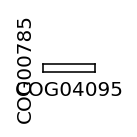

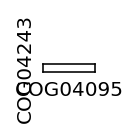

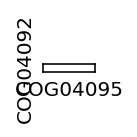

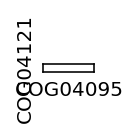

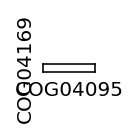

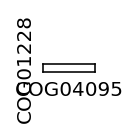

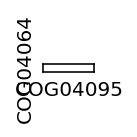

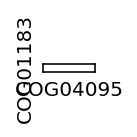

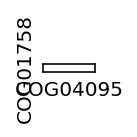

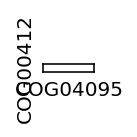

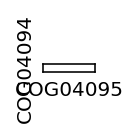

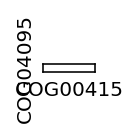

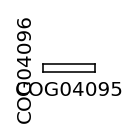

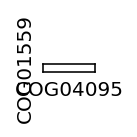

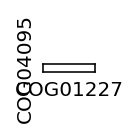

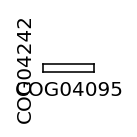

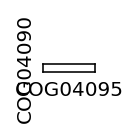

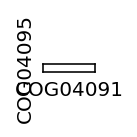

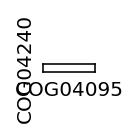

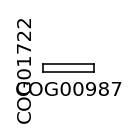

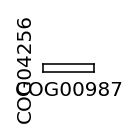

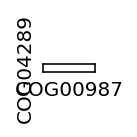

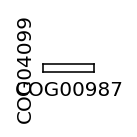

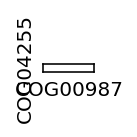

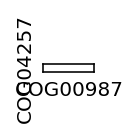

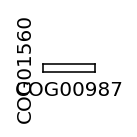

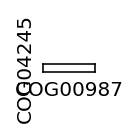

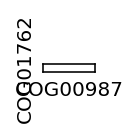

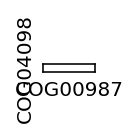

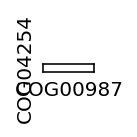

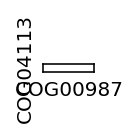

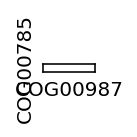

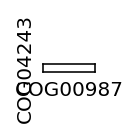

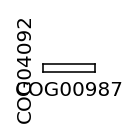

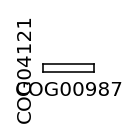

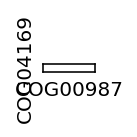

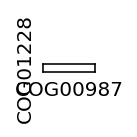

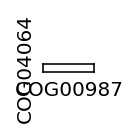

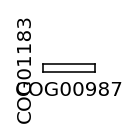

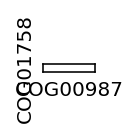

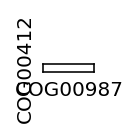

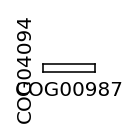

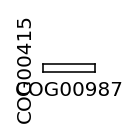

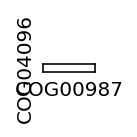

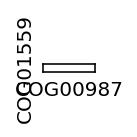

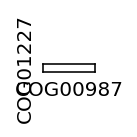

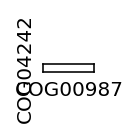

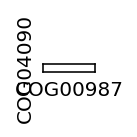

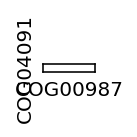

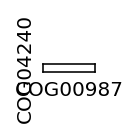

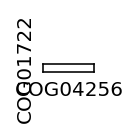

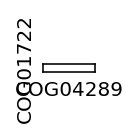

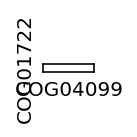

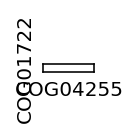

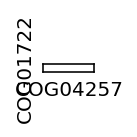

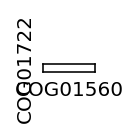

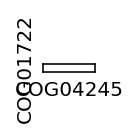

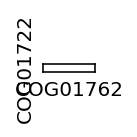

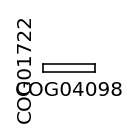

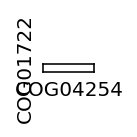

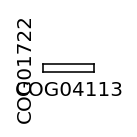

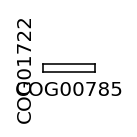

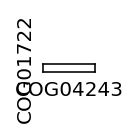

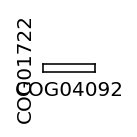

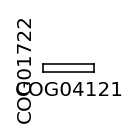

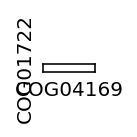

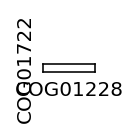

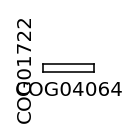

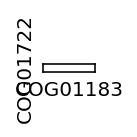

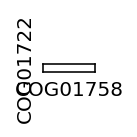

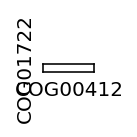

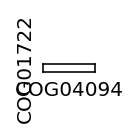

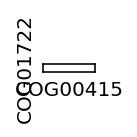

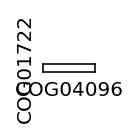

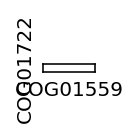

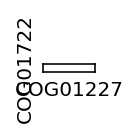

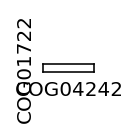

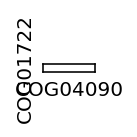

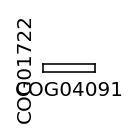

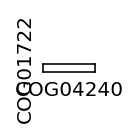

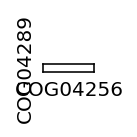

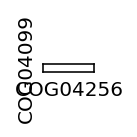

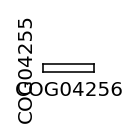

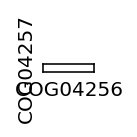

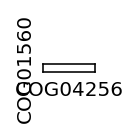

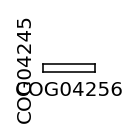

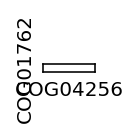

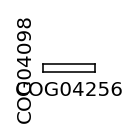

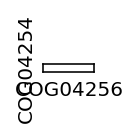

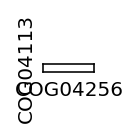

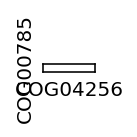

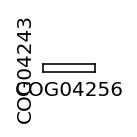

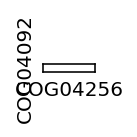

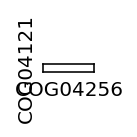

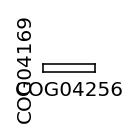

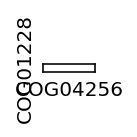

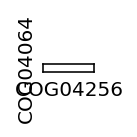

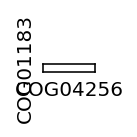

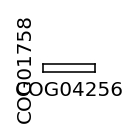

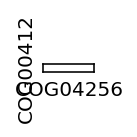

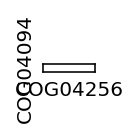

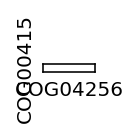

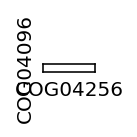

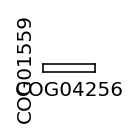

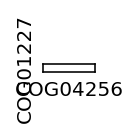

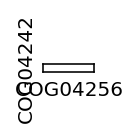

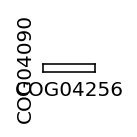

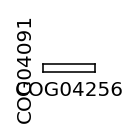

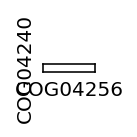

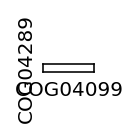

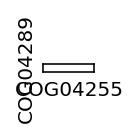

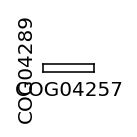

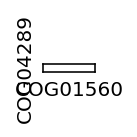

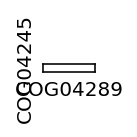

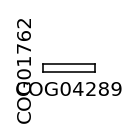

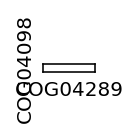

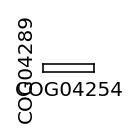

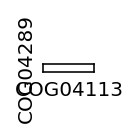

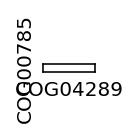

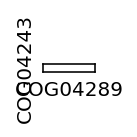

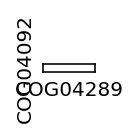

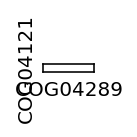

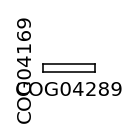

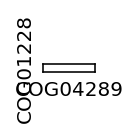

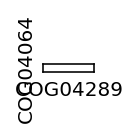

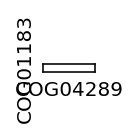

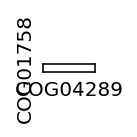

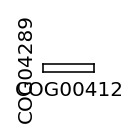

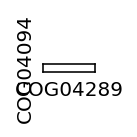

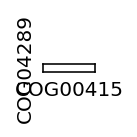

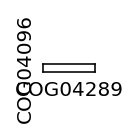

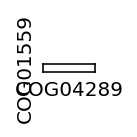

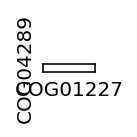

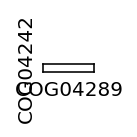

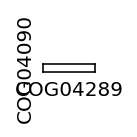

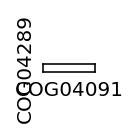

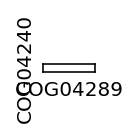

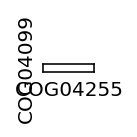

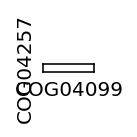

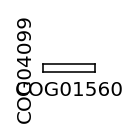

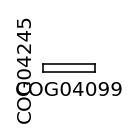

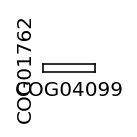

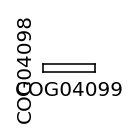

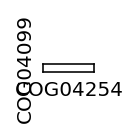

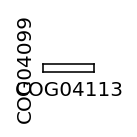

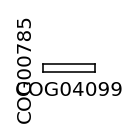

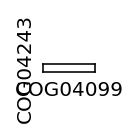

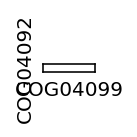

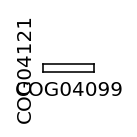

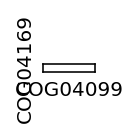

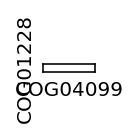

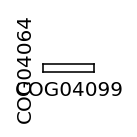

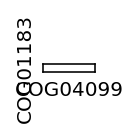

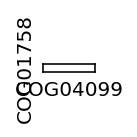

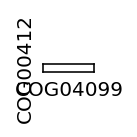

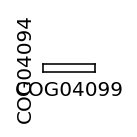

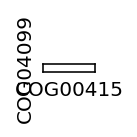

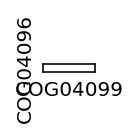

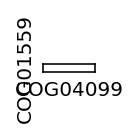

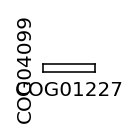

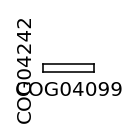

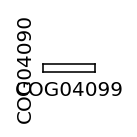

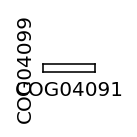

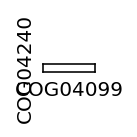

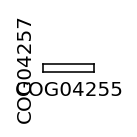

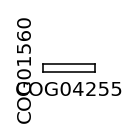

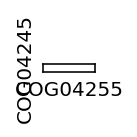

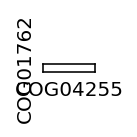

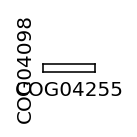

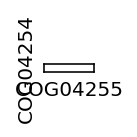

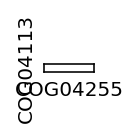

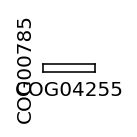

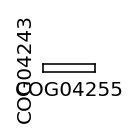

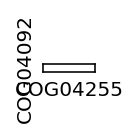

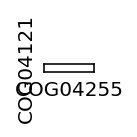

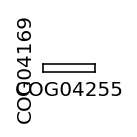

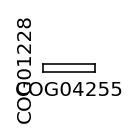

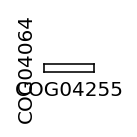

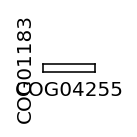

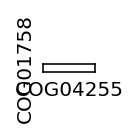

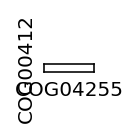

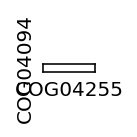

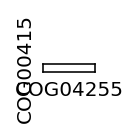

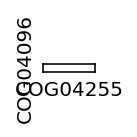

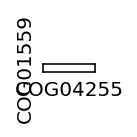

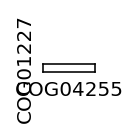

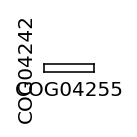

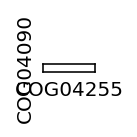

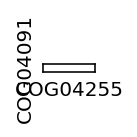

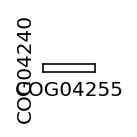

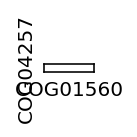

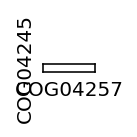

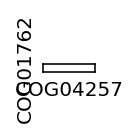

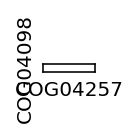

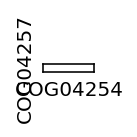

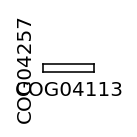

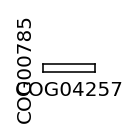

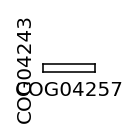

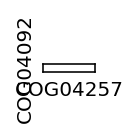

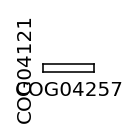

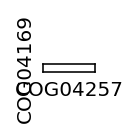

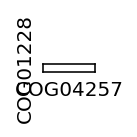

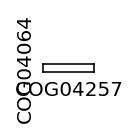

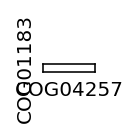

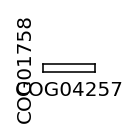

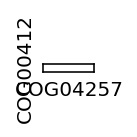

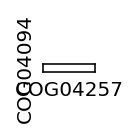

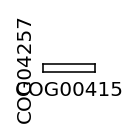

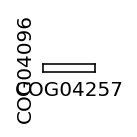

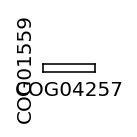

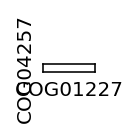

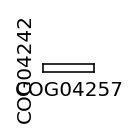

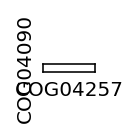

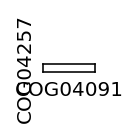

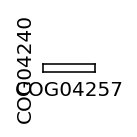

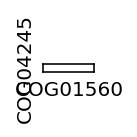

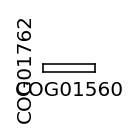

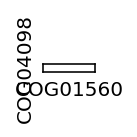

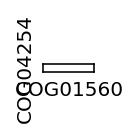

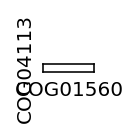

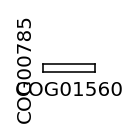

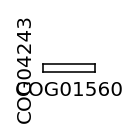

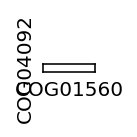

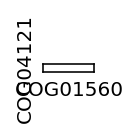

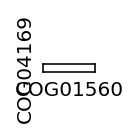

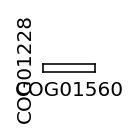

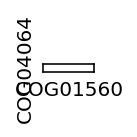

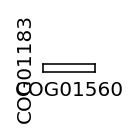

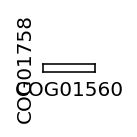

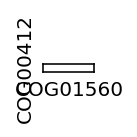

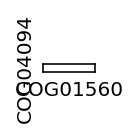

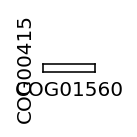

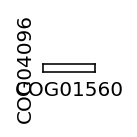

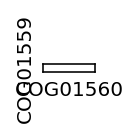

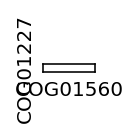

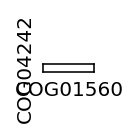

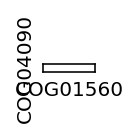

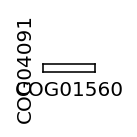

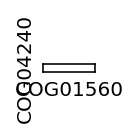

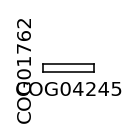

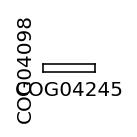

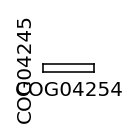

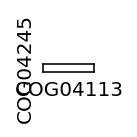

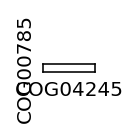

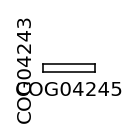

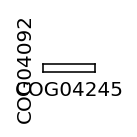

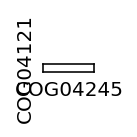

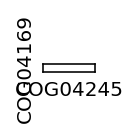

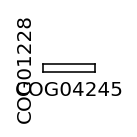

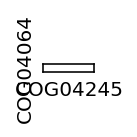

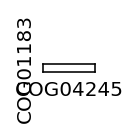

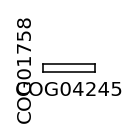

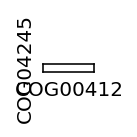

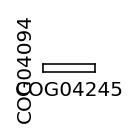

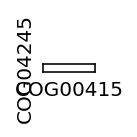

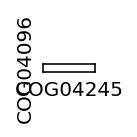

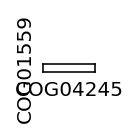

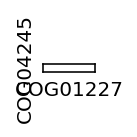

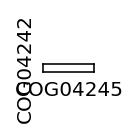

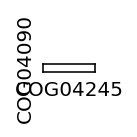

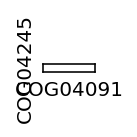

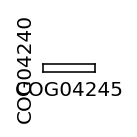

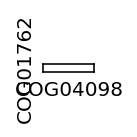

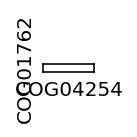

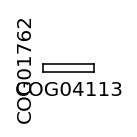

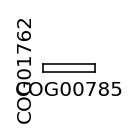

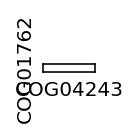

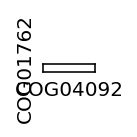

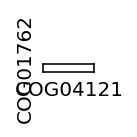

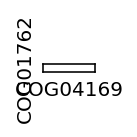

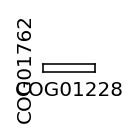

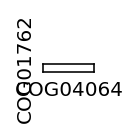

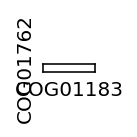

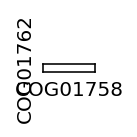

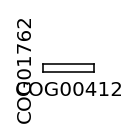

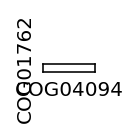

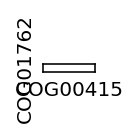

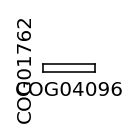

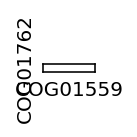

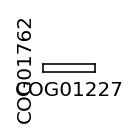

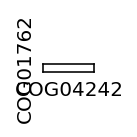

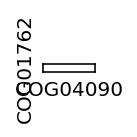

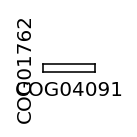

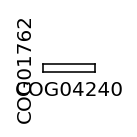

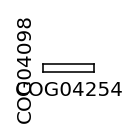

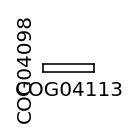

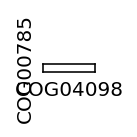

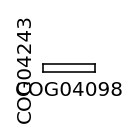

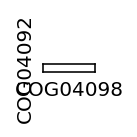

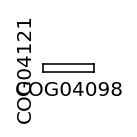

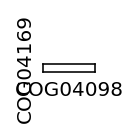

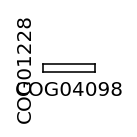

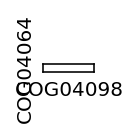

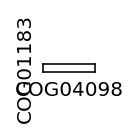

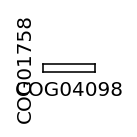

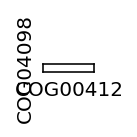

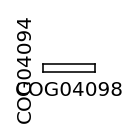

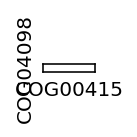

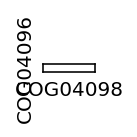

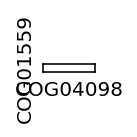

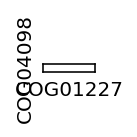

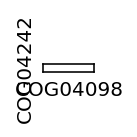

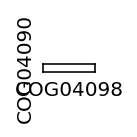

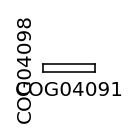

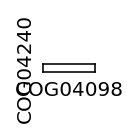

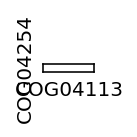

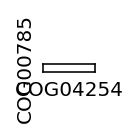

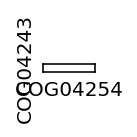

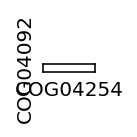

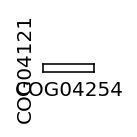

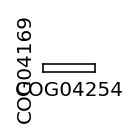

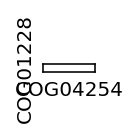

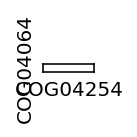

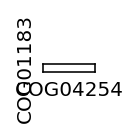

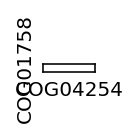

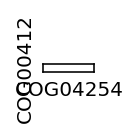

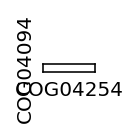

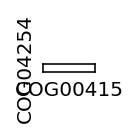

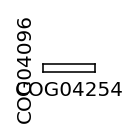

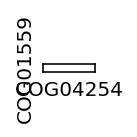

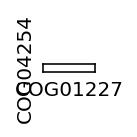

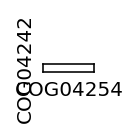

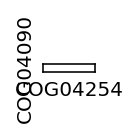

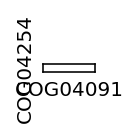

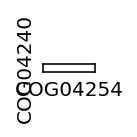

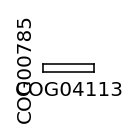

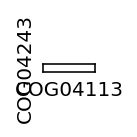

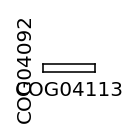

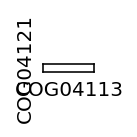

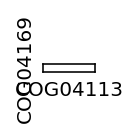

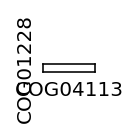

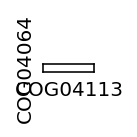

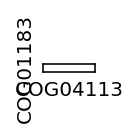

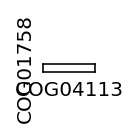

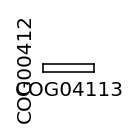

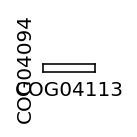

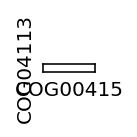

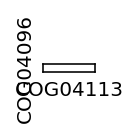

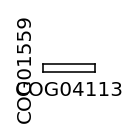

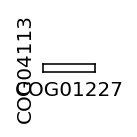

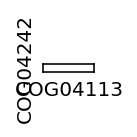

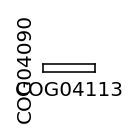

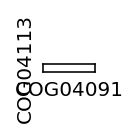

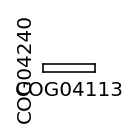

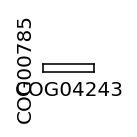

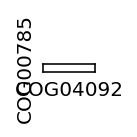

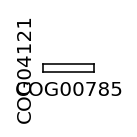

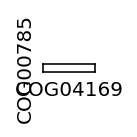

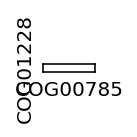

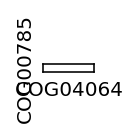

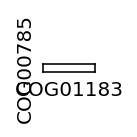

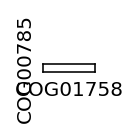

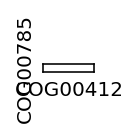

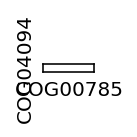

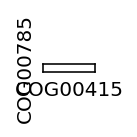

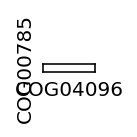

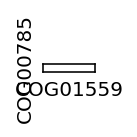

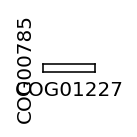

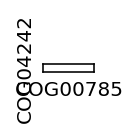

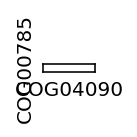

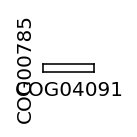

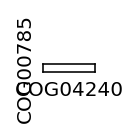

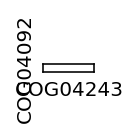

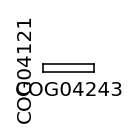

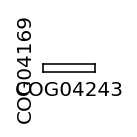

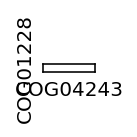

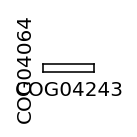

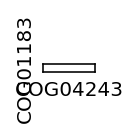

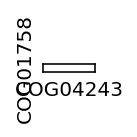

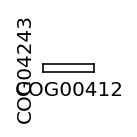

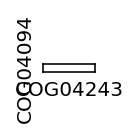

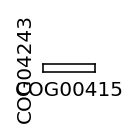

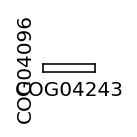

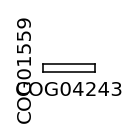

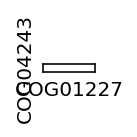

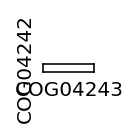

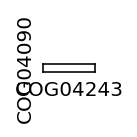

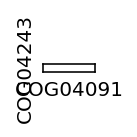

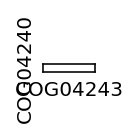

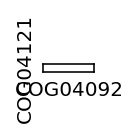

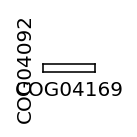

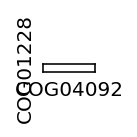

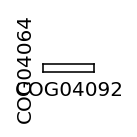

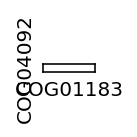

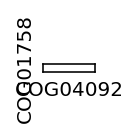

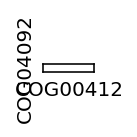

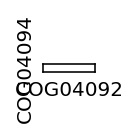

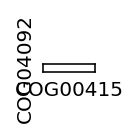

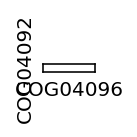

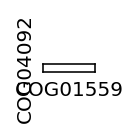

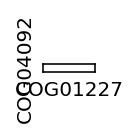

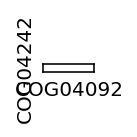

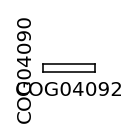

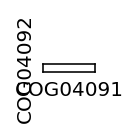

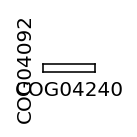

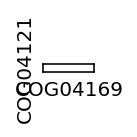

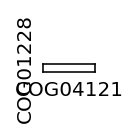

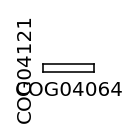

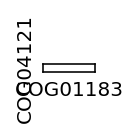

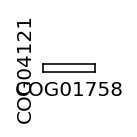

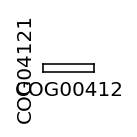

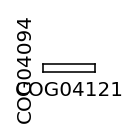

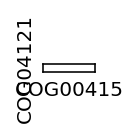

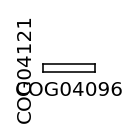

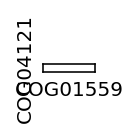

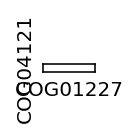

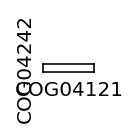

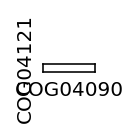

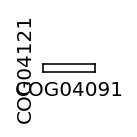

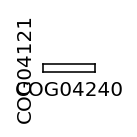

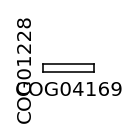

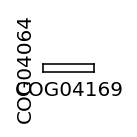

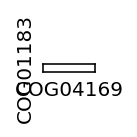

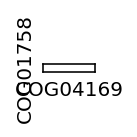

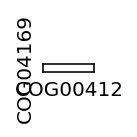

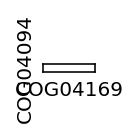

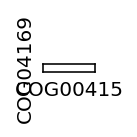

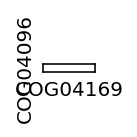

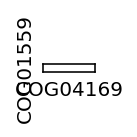

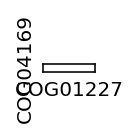

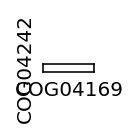

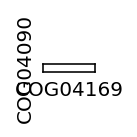

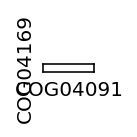

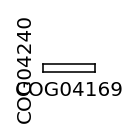

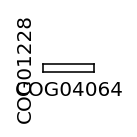

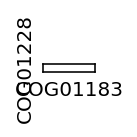

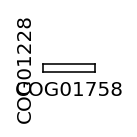

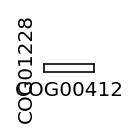

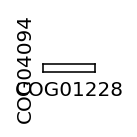

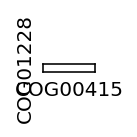

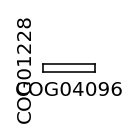

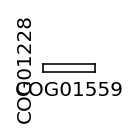

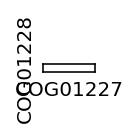

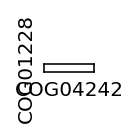

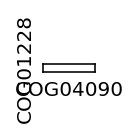

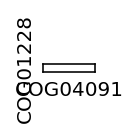

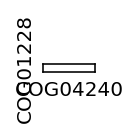

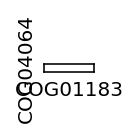

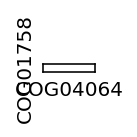

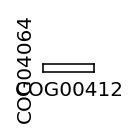

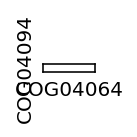

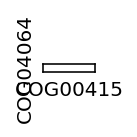

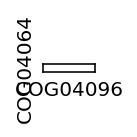

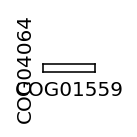

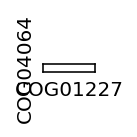

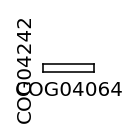

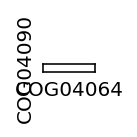

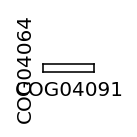

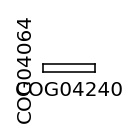

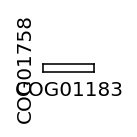

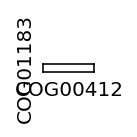

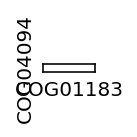

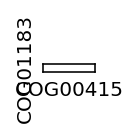

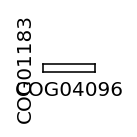

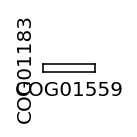

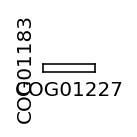

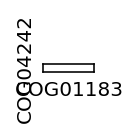

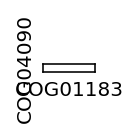

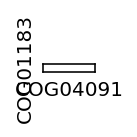

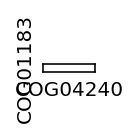

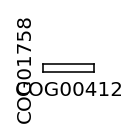

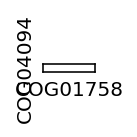

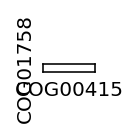

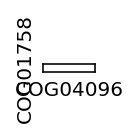

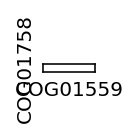

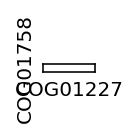

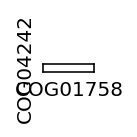

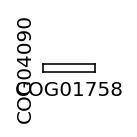

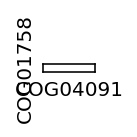

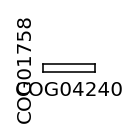

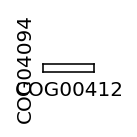

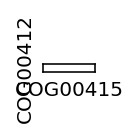

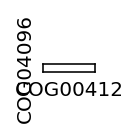

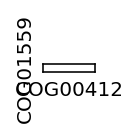

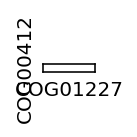

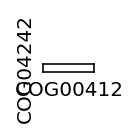

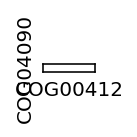

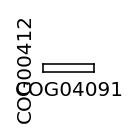

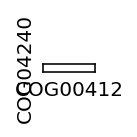

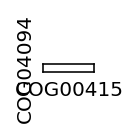

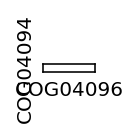

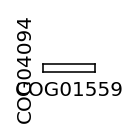

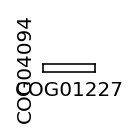

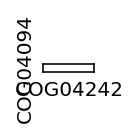

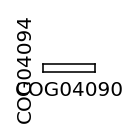

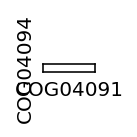

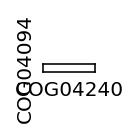

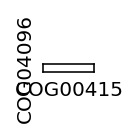

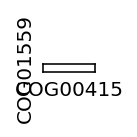

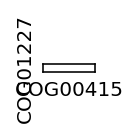

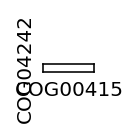

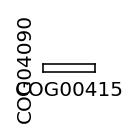

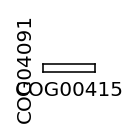

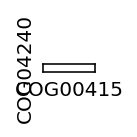

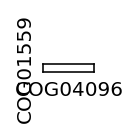

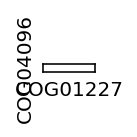

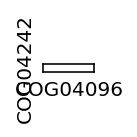

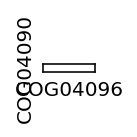

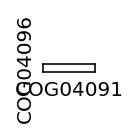

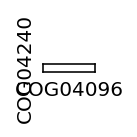

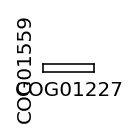

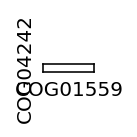

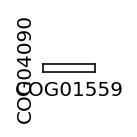

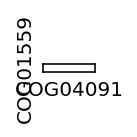

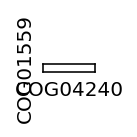

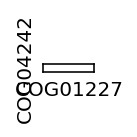

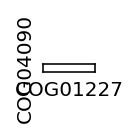

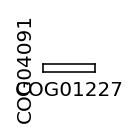

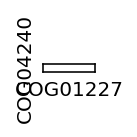

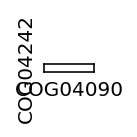

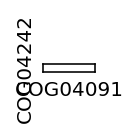

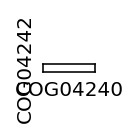

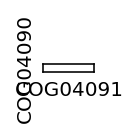

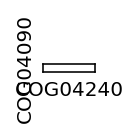

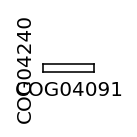

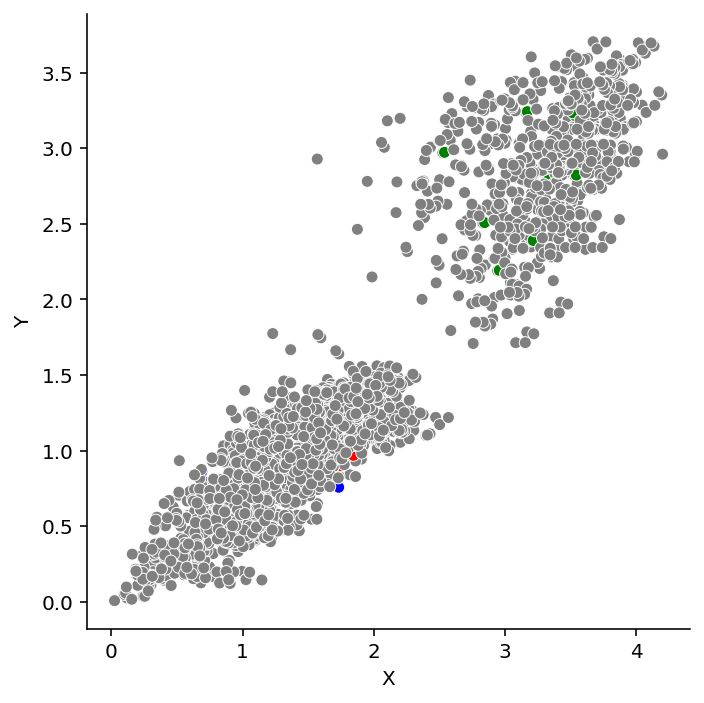

In [160]:
figure( figsize=(12,60) )
for n,I in enumerate( distances.keys() ) :
    ax = subplot( 60, 10, n + 1 )
    #ax.axis( 'off' )
    #ax.set_facecolor( '#eeeeee' )
    #for axis in ['top', 'bottom', 'left', 'right'] :
    #    ax.spines[axis].set_linewidth(0)
    xticks( [] )
    yticks( [] )
    x,y = I
    df = distances[I]
    #title( x.split('-final.')[0] + '\nvs.\n' + y.split('-final.')[0] )
    xlabel( x )
    ylabel( y )
    #scatter( distances[I][x], 
    #         distances[I][y],
    #         alpha=0.25, lw=0, s=7 )
    seaborn.relplot( x='X', y='Y', hue='label', data=df, palette=palette, legend=None )
tight_layout()

In [21]:
congruences_r = numpy.zeros( ( len(forest), len(forest) ) )
pvalues_r     = numpy.zeros( ( len(forest), len(forest) ) )
congruences_t = numpy.zeros( ( len(forest), len(forest) ) )
pvalues_t     = numpy.zeros( ( len(forest), len(forest) ) )
for i,a in enumerate( forest.keys() ) :
    T1 = forest[a]
    for j,b in enumerate( forest.keys() ) :
        T2 = forest[b]
        leafs = set( T1.leafs.keys() ) & set( T2.leafs.keys() )
        X = T1.distances_by_name( list( combinations( leafs, 2 ) ) )
        Y = T2.distances_by_name( list( combinations( leafs, 2 ) ) )
        congruences_r[i,j], pvalues_r[i,j] = pearsonr( X, Y )
        congruences_t[i,j], pvalues_t[i,j] = kendalltau( X, Y )

names = [ name.split('.treefile')[0][2:] for name in forest.keys() ]
cong_r = pandas.DataFrame( congruences_r, columns=names, index=names )
pv_r   = pandas.DataFrame( pvalues_r,     columns=names, index=names )
cong_t = pandas.DataFrame( congruences_t, columns=names, index=names )
pv_t   = pandas.DataFrame( pvalues_t,     columns=names, index=names )

In [22]:
cong_t

,COG04241,COG04095,COG00987,COG01722,COG04256,COG04289,COG04099,COG04255,COG04257,COG01560,...,COG00412,COG04094,COG00415,COG04096,COG01559,COG01227,COG04242,COG04090,COG04091,COG04240
COG04241,1.000000,0.543116,0.609306,0.587793,0.620210,0.551691,0.550302,0.567472,0.665784,0.654486,...,0.546732,0.559162,0.622009,0.559799,0.643411,0.493100,0.632521,0.547173,0.594228,0.653217
COG04095,0.543116,1.000000,0.555362,0.647780,0.568408,0.519523,0.660001,0.639000,0.622528,0.626117,...,0.516021,0.617900,0.630044,0.622739,0.635083,0.541817,0.569966,0.626217,0.585565,0.631523
COG00987,0.609306,0.555362,1.000000,0.624557,0.586240,0.498318,0.594950,0.524419,0.589678,0.628831,...,0.604651,0.631332,0.595160,0.553642,0.603075,0.493515,0.542635,0.576880,0.655970,0.705669
COG01722,0.587793,0.647780,0.624557,1.000000,0.576896,0.542907,0.658593,0.581469,0.612198,0.676896,...,0.537521,0.623311,0.600202,0.570133,0.649023,0.505395,0.578062,0.603591,0.608520,0.633497
COG04256,0.620210,0.568408,0.586240,0.576896,1.000000,0.596275,0.664546,0.722331,0.789466,0.777116,...,0.649539,0.611457,0.718042,0.677739,0.742324,0.610274,0.669946,0.676645,0.718652,0.688980
COG04289,0.551691,0.519523,0.498318,0.542907,0.596275,1.000000,0.563909,0.659565,0.661415,0.657181,...,0.596862,0.481968,0.627033,0.584551,0.650842,0.627674,0.623385,0.610609,0.629283,0.591196
COG04099,0.550302,0.660001,0.594950,0.658593,0.664546,0.563909,1.000000,0.679567,0.700202,0.696817,...,0.600719,0.654888,0.647324,0.580213,0.667593,0.563246,0.590591,0.660932,0.655026,0.660750
COG04255,0.567472,0.639000,0.524419,0.581469,0.722331,0.659565,0.679567,1.000000,0.781609,0.732035,...,0.615565,0.572475,0.716135,0.685132,0.761104,0.607358,0.691571,0.665539,0.684357,0.665168
COG04257,0.665784,0.622528,0.589678,0.612198,0.789466,0.661415,0.700202,0.781609,1.000000,0.793699,...,0.663936,0.604613,0.733645,0.678703,0.779460,0.658886,0.714011,0.682622,0.714978,0.697220
COG01560,0.654486,0.626117,0.628831,0.676896,0.777116,0.657181,0.696817,0.732035,0.793699,1.000000,...,0.651028,0.670880,0.731367,0.715979,0.792223,0.635592,0.675271,0.736051,0.727465,0.739915


In [25]:
pv_t.max()

COG04241    5.036494e-185
COG04095     0.000000e+00
COG00987    2.443187e-227
COG01722    1.311954e-222
COG04256    1.137737e-220
COG04289    3.892767e-227
COG04099    3.137948e-257
COG04255    3.209129e-225
COG04257    2.495834e-243
COG01560    3.993092e-273
COG04245    7.528721e-282
COG01762    1.318982e-215
COG04098    2.617419e-261
COG04254    9.901986e-211
COG04113    6.320589e-268
COG00785     1.169635e-83
COG04243     0.000000e+00
COG04092    2.837771e-190
COG04121     1.169635e-83
COG04169    5.614607e-191
COG01228    2.057927e-196
COG04064    6.212746e-155
COG01183    1.740072e-226
COG01758    8.380815e-212
COG00412    5.916399e-165
COG04094    1.969174e-240
COG00415    4.263938e-279
COG04096    2.460628e-227
COG01559    1.911160e-226
COG01227    4.155498e-205
COG04242    2.569333e-159
COG04090    9.226625e-284
COG04091    1.262090e-265
COG04240    4.691979e-252
dtype: float64

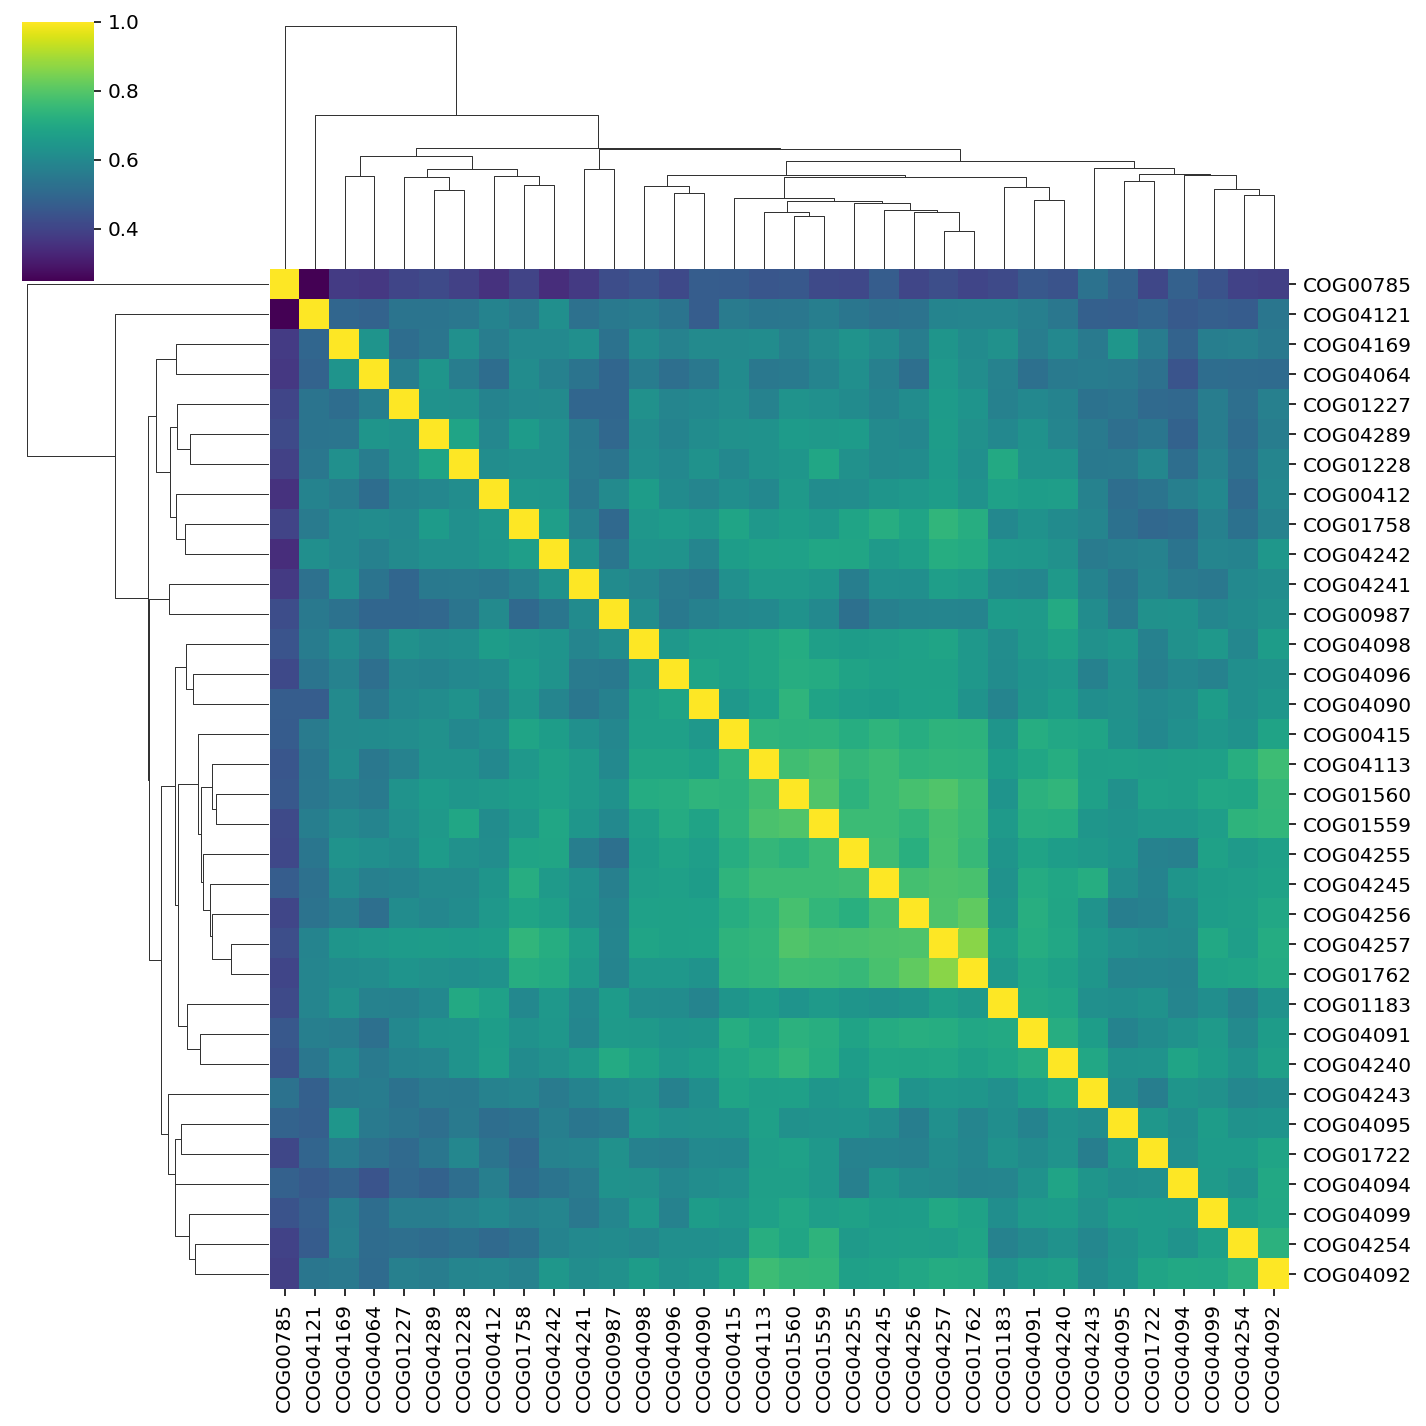

In [24]:
seaborn.clustermap( cong_t, figsize=(10,10), cmap='viridis' )